## Visualizing VGG-S filters

This is an ipython notebook to generate visualizations of VGG-S filters, for some more info refer to [this blogpost](https://auduno.github.io/2016/06/18/peeking-inside-convnets/).

To run this code, you'll need an installation of Caffe with built pycaffe libraries, as well as the python libraries numpy, scipy and PIL. For instructions on how to install Caffe and pycaffe, refer to the installation guide [here](http://caffe.berkeleyvision.org/installation.html). Before running the ipython notebooks, you'll also need to download the [VGG-S model](https://gist.github.com/ksimonyan/fd8800eeb36e276cd6f9), and modify the variables ```pycaffe_root``` to refer to the path of your pycaffe installation (if it's not already in your python path) and ```model_path``` to refer to the path of the downloaded VGG-S caffe model. Also uncomment the line that enables GPU mode if you have built Caffe with GPU-support and a suitable GPU available.


In [2]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import os,re,random
import scipy.ndimage as nd
import PIL.Image
import sys
from IPython.display import clear_output, Image, display
from scipy.misc import imresize

pycaffe_root = "/your/path/here/caffe/python" # substitute your path here
sys.path.insert(0, pycaffe_root)
import caffe

model_name="VGGS"
model_path = '/your/path/here/vggs_model/' # substitute your path here
net_fn   = './VGG_CNN_S_deploy_mod.prototxt' # added force_backward : true to prototxt
param_fn = model_path + 'VGG_CNN_S.caffemodel'
means = np.float32([104.0, 117.0, 123.0])

#caffe.set_mode_gpu() # uncomment this if gpu processing is available

net = caffe.Classifier(net_fn, param_fn,
                       mean = means, # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def blur(img, sigma):
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img

def showarray(a, f, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:
def make_step(net, step_size=1.5, end='inception_4c/output', clip=True, focus=None, sigma=None):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob

    dst = net.blobs[end]
    net.forward(end=end)
    
    one_hot = np.zeros_like(dst.data)
    filter_shape = dst.data.shape
    if len(filter_shape) > 2:
        # backprop only activation in middle of filter
        one_hot[0,focus,(filter_shape[2]-1)/2,(filter_shape[3]-1)/2] = 1.
    else:
        one_hot.flat[focus] = 1.
    dst.diff[:] = one_hot
    
    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias) 
        
    src.data[0] = blur(src.data[0], sigma)
    
    dst.diff.fill(0.)

def deepdraw(net, base_img, octaves, random_crop=True, visualize=True, focus=None,
    clip=True, **step_params):
    
    # prepare base image
    image = preprocess(net, base_img) # (3,224,224)
    
    # get input dimensions from net
    w = net.blobs['data'].width
    h = net.blobs['data'].height
    
    print "starting drawing"
    src = net.blobs['data']
    src.reshape(1,3,h,w) # resize the network's input image size
    for e,o in enumerate(octaves):
        if 'scale' in o:
            # resize by o['scale'] if it exists
            image = nd.zoom(image, (1,o['scale'],o['scale']))
        _,imw,imh = image.shape
        
        # select layer
        layer = o['layer']
        
        for i in xrange(o['iter_n']):
            if imw > w:
                if random_crop:
                    # randomly select a crop 
                    #ox = random.randint(0,imw-224)
                    #oy = random.randint(0,imh-224)
                    mid_x = (imw-w)/2.
                    width_x = imw-w
                    ox = np.random.normal(mid_x, width_x*0.3, 1)
                    ox = int(np.clip(ox,0,imw-w))
                    mid_y = (imh-h)/2.
                    width_y = imh-h
                    oy = np.random.normal(mid_y, width_y*0.3, 1)
                    oy = int(np.clip(oy,0,imh-h))
                    # insert the crop into src.data[0]
                    src.data[0] = image[:,ox:ox+w,oy:oy+h]
                else:
                    ox = (imw-w)/2.
                    oy = (imh-h)/2.
                    src.data[0] = image[:,ox:ox+w,oy:oy+h]
            else:
                ox = 0
                oy = 0
                src.data[0] = image.copy()

            sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
            step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']
            
            make_step(net, end=layer, clip=clip, focus=focus, 
                      sigma=sigma, step_size=step_size)
            
            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: # adjust image contrast if clipping is disabled
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                if i % 1 == 0:
                    showarray(vis,"./filename"+str(i)+".jpg")
            
            if i % 10 == 0:
                print 'finished step %d in octave %d' % (i,e)
            
            # insert modified image back into original image (if necessary)
            image[:,ox:ox+w,oy:oy+h] = src.data[0]
        
        print "octave %d image:" % e
        showarray(deprocess(net, image),"./octave_"+str(e)+".jpg")
            
    # returning the resulting image
    return deprocess(net, image)

starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
finished step 190 in octave 0
octave 0 image:


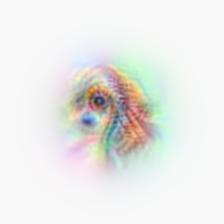

finished step 0 in octave 1
finished step 10 in octave 1
finished step 20 in octave 1
finished step 30 in octave 1
finished step 40 in octave 1
finished step 50 in octave 1
finished step 60 in octave 1
finished step 70 in octave 1
finished step 80 in octave 1
finished step 90 in octave 1
octave 1 image:


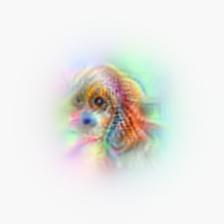

finished step 0 in octave 2
finished step 10 in octave 2
finished step 20 in octave 2
finished step 30 in octave 2
finished step 40 in octave 2
finished step 50 in octave 2
finished step 60 in octave 2
finished step 70 in octave 2
finished step 80 in octave 2
finished step 90 in octave 2
octave 2 image:


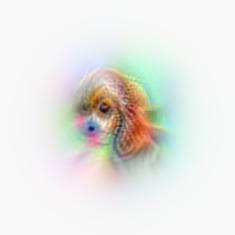

finished step 0 in octave 3
finished step 10 in octave 3
finished step 20 in octave 3
finished step 30 in octave 3
finished step 40 in octave 3
octave 3 image:


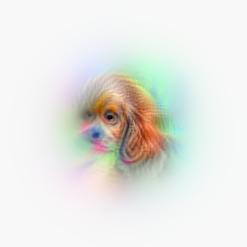

finished step 0 in octave 4
finished step 10 in octave 4
finished step 20 in octave 4
octave 4 image:


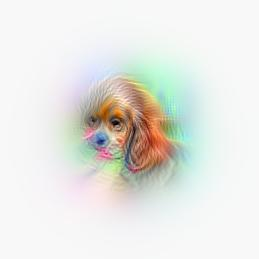

In [6]:
octaves = [
    {
        'layer':'conv5',
        'iter_n':200,
        'start_sigma':2.5,
        'end_sigma':1.1,
        'start_step_size':12.*0.25,
        'end_step_size':10.*0.25,
    },
    {
        'layer':'conv5',
        'iter_n':100,
        'start_sigma':1.1,
        'end_sigma':0.78*1.1,
        'start_step_size':10.*0.25,
        'end_step_size':8.*0.25
    },
    {
        'layer':'conv5',
        'scale':1.05,
        'iter_n':100,
        'start_sigma':0.78*1.1,
        'end_sigma':0.78,
        'start_step_size':8.*0.25,
        'end_step_size':6.*0.25
    },
    {
        'layer':'conv5',
        'scale':1.05,
        'iter_n':50,
        'start_sigma':0.78*1.1,
        'end_sigma':0.40,
        'start_step_size':6.*0.25,
        'end_step_size':1.5*0.25
    },
    {
        'layer':'conv5',
        'scale':1.05,
        'iter_n':25,
        'start_sigma':0.4,
        'end_sigma':0.1,
        'start_step_size':1.5*0.25,
        'end_step_size':0.5*0.25
    }
]

# get original input size of network
original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
# the background color of the initial image
background_color = np.float32([250.0, 250.0, 250.0])
# generate initial random image
gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3))

# which filter in layer to visualize (conv5 has 512 filters)
imagenet_class = 10

# generate class visualization via octavewise gradient ascent
gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, 
                 random_crop=True, visualize=False)

# save image
#img_fn = '_'.join([model_name, "deepdraw", str(imagenet_class)+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)